In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from feature_engine.selection import DropFeatures
from feature_engine.creation import CombineWithReferenceFeature
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.model_selection import (
    cross_val_score,
    RepeatedStratifiedKFold,
    learning_curve,
)
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    plot_roc_curve,
)
import optuna
import warnings


# Config
%matplotlib inline
%load_ext nb_black
%load_ext lab_black
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

/home/bobcasta/.churnenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

In [2]:
X_train = pd.read_csv("../data/raw/train.csv")
X_test = pd.read_csv("../data/raw/test.csv")

<IPython.core.display.Javascript object>

In [3]:
X_train["Churn"] = X_train["Churn"].map({"Yes": 1, "No": 0})
X_test["Churn"] = X_test["Churn"].map({"Yes": 1, "No": 0})

<IPython.core.display.Javascript object>

In [4]:
def casting_numerical(dataframe, numerical_feature):
    """Cast features to the correct type."""
    dataframe[numerical_feature] = dataframe[numerical_feature].apply(
        lambda dataframe: str(dataframe).replace(",", "."),
    )
    dataframe[numerical_feature] = pd.to_numeric(
        dataframe[numerical_feature], errors="coerce"
    )
    dataframe[numerical_feature] = dataframe[numerical_feature].astype("float64")
    dataframe[numerical_feature] = dataframe[numerical_feature].replace("", np.nan)
    return dataframe


def casting_categorical(dataframe, categorical_feature):
    """Cast features to the correct type."""
    dataframe[categorical_feature] = dataframe[categorical_feature].astype("object")
    return dataframe


def change_no_service_to_no(dataframe):
    for col in dataframe.columns:
        if dataframe[col].dtype == "object":
            dataframe[col] = dataframe[col].replace("No phone service", "No")
            dataframe[col] = dataframe[col].replace("No internet service", "No")
    return dataframe

<IPython.core.display.Javascript object>

In [5]:
# apply casting_numerical function to X_train and X_test simultaneously
X_train, X_test = map(
    lambda dataframe: casting_numerical(dataframe, "TotalCharges"),
    [X_train, X_test],
)

X_train, X_test = map(
    lambda dataframe: casting_categorical(dataframe, "SeniorCitizen"),
    [X_train, X_test],
)

X_train, X_test = map(
    lambda dataframe: change_no_service_to_no(dataframe),
    [X_train, X_test],
)

<IPython.core.display.Javascript object>

In [6]:
# dropna from X_train and X_test simultaneously
X_train, X_test = map(lambda dataframe: dataframe.dropna(), [X_train, X_test])

<IPython.core.display.Javascript object>

In [7]:
y_train = X_train["Churn"]
X_train = X_train.drop("Churn", axis=1)

y_test = X_test["Churn"]
X_test = X_test.drop("Churn", axis=1)

<IPython.core.display.Javascript object>

In [8]:
preprocessor = Pipeline(
    [
        ("drop_vars", DropFeatures(["customerID"])),
        (
            "tenure_combine",
            CombineWithReferenceFeature(
                variables_to_combine=["MonthlyCharges", "TotalCharges"],
                reference_variables=["tenure"],
                operations=["div"],
                new_variables_names=["tenureMonthlyRate", "tenureTotalRate"],
            ),
        ),
        (
            "totalcharges_combine",
            CombineWithReferenceFeature(
                variables_to_combine=["TotalCharges"],
                reference_variables=["MonthlyCharges"],
                operations=["div"],
                new_variables_names=["RateCharge"],
            ),
        ),
        (
            "preprocessor",
            ColumnTransformer(
                [
                    (
                        "num",
                        make_pipeline(
                            SimpleImputer(strategy="median"),
                        ),
                        make_column_selector(dtype_include=np.number),
                    ),
                    (
                        "cat",
                        make_pipeline(
                            SimpleImputer(strategy="most_frequent"),
                            TargetEncoder(),
                        ),
                        make_column_selector(dtype_include=["object"]),
                    ),
                ],
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

# Create a function to optimize the hyperparameters
def objective(trial):
    """Objective function for Gradient Boosting Hyperparameter Optimization."""
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 25),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 25),
        # "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt"]),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "random_state": 42,
    }

    pipeline = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("model", GradientBoostingClassifier(**params)),
        ]
    )

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    return np.mean(
        cross_val_score(
            pipeline,
            X_train,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1,
        )
    )

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

optuna.visualization.plot_optimization_history(study)

optuna.visualization.plot_param_importances(study)

In [9]:
# train the model with the best hyperparameters
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "model",
            GradientBoostingClassifier(
                n_estimators=700,
                learning_rate=0.0033570,
                max_depth=5,
                min_samples_split=6,
                min_samples_leaf=21,
                subsample=0.65,
                random_state=42,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

In [10]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(
    pipeline, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1
)
print("Mean ROC AUC: %.3f" % np.mean(scores), "Std ROC AUC: %.3f" % np.std(scores))

/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/

Mean ROC AUC: 0.847 Std ROC AUC: 0.011


<IPython.core.display.Javascript object>

/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/

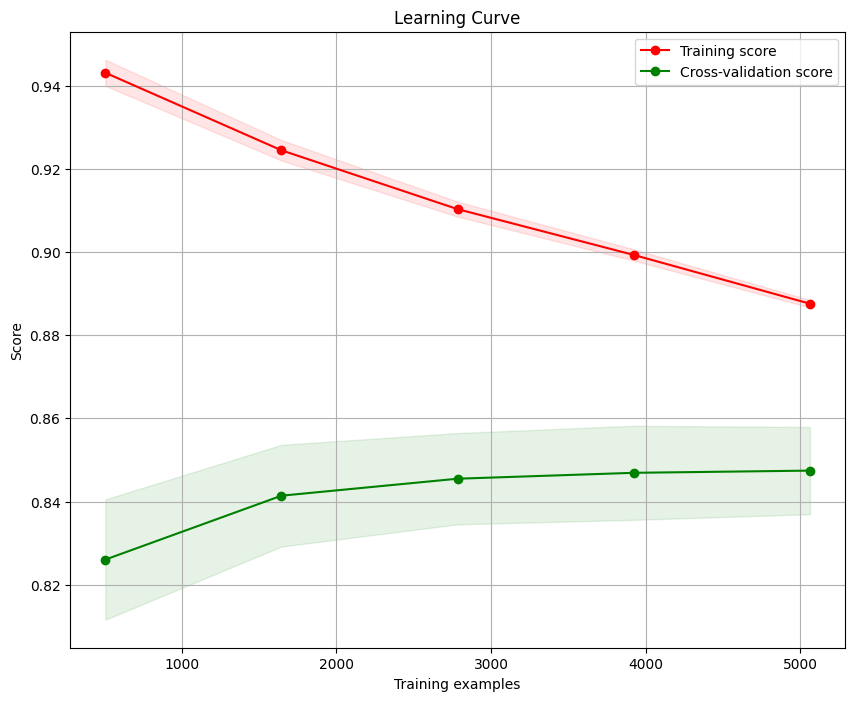

<IPython.core.display.Javascript object>

In [11]:
results = learning_curve(
    pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1
)
train_sizes, train_scores, test_scores = results[:3]
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 8))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()